In [ ]:
pip install opencv-python matplotlib numpy

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving hazy6.jpg to hazy6.jpg


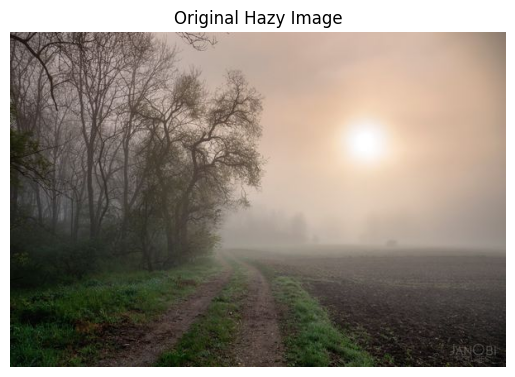

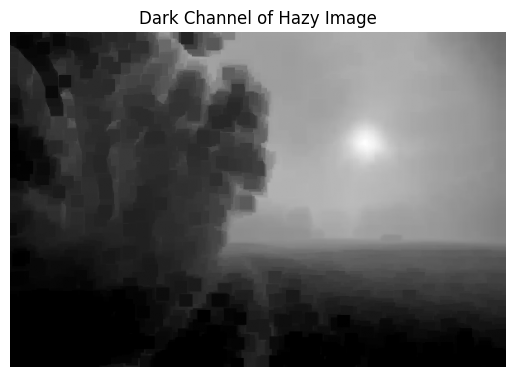

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def load_image(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    else:
        img = img.astype(np.uint8)
    return img


def get_dark_channel(image, patch_size=15):
    min_channel = np.min(image, axis=2)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (patch_size, patch_size))
    dark_channel = cv2.erode(min_channel, kernel)
    return dark_channel


def show_image(img, title='Image'):
    plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
    plt.title(title)
    plt.axis('off')
    plt.show()



image_path = list(uploaded.keys())[0]  # First uploaded image
image = load_image(image_path)
dark_channel = get_dark_channel(image)

show_image(image, "Original Hazy Image")
show_image(dark_channel, "Dark Channel of Hazy Image")


In [ ]:
def estimate_atmospheric_light(I, dark_channel, top_percent=0.001):
    h, w = dark_channel.shape
    num_pixels = h * w
    num_brightest = int(max(top_percent * num_pixels, 1))

    # Flatten dark channel and get indices of brightest pixels
    flat_dark = dark_channel.ravel()
    indices = np.argsort(flat_dark)[-num_brightest:]

    # Get corresponding pixels from original image
    brightest = I.reshape(num_pixels, 3)[indices]

    # Atmospheric light is the max intensity across these brightest pixels
    A = np.max(brightest, axis=0)
    return A

dark_channel = get_dark_channel(image, patch_size=15)
A = estimate_atmospheric_light(image, dark_channel)
print("Atmospheric Light A:", A)



Atmospheric Light A: [255 255 255]


In [ ]:
def estimate_transmission(image, A, patch_size=15, omega=0.95):

    norm_image = image / A  # Element-wise division (broadcasted across channels)

    dark_channel = get_dark_channel(norm_image, patch_size)

    transmission = 1 - omega * dark_channel

    return transmission

import matplotlib.pyplot as plt

def show_transmission_map(transmission):
    plt.figure(figsize=(8, 6))
    plt.imshow(transmission, cmap='gray')
    plt.title("Estimated Transmission Map")
    plt.axis('off')
    plt.colorbar()
    plt.show()


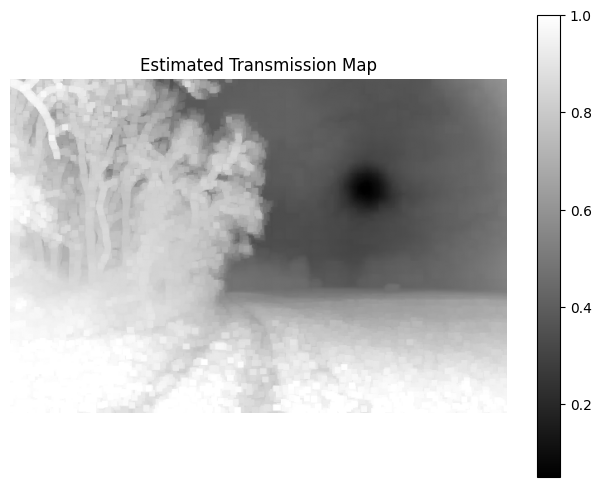

In [ ]:
transmission = estimate_transmission(image, A, patch_size=7)
show_transmission_map(transmission)

In [ ]:
#TEST

In [ ]:
def guided_filter(I, p, r, eps):

    mean_I = cv2.boxFilter(I, cv2.CV_32F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_32F, (r, r))
    mean_Ip = cv2.boxFilter(I * p, cv2.CV_32F, (r, r))
    mean_II = cv2.boxFilter(I * I, cv2.CV_32F, (r, r))

    cov_Ip = mean_Ip - mean_I * mean_p
    var_I = mean_II - mean_I * mean_I

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_32F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_32F, (r, r))

    q = mean_a * I + mean_b
    return q


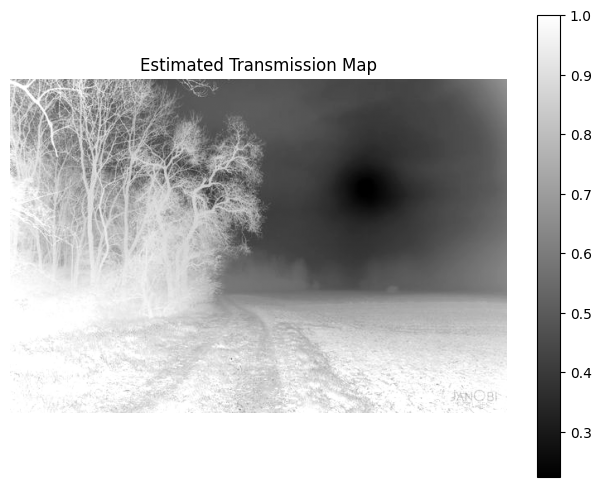

In [ ]:
gray_guide = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY).astype(np.float32) / 255.0

transmission = transmission.astype(np.float32)
if transmission.max() > 1.0:
    transmission = transmission / 255.0

refined_transmission = guided_filter(gray_guide, transmission, r = 1000, eps=1e-3)
#r changed from 40
refined_transmission = np.clip(refined_transmission, 0.1, 1.0)


show_transmission_map(refined_transmission)

In [ ]:
#TEST

In [ ]:
def recover_scene_radiance(I, A, t, t0=0.1):#t0 was 0.1
    I = I.astype(np.float32)
    t = np.maximum(t, t0)[:, :, np.newaxis]
    J = (I - A) / t + A
    J = np.clip(J, 0, 255).astype(np.uint8)
    return J

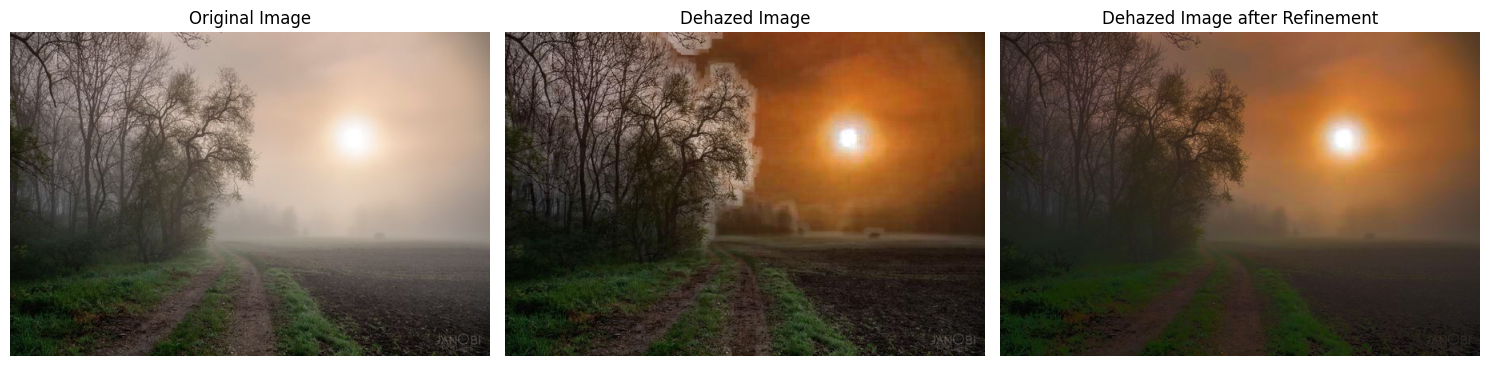

In [ ]:
# Compute dark channel and transmission
dark_channel = get_dark_channel(image, patch_size=15)
A = estimate_atmospheric_light(image, dark_channel)
transmission = estimate_transmission(image, A, omega=0.95, patch_size=15)

# Recover the dehazed image
J = recover_scene_radiance(image, A, transmission)
J2 = recover_scene_radiance(image, A, refined_transmission)


plt.figure(figsize=(15, 5))

# Plot Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis('off')

# Plot Dehazed Image
plt.subplot(1, 3, 2)
plt.imshow(J)
plt.title("Dehazed Image")
plt.axis('off')

# Plot Dehazed Image after Refinement
plt.subplot(1, 3, 3)
plt.imshow(J2)
plt.title("Dehazed Image after Refinement")
plt.axis('off')

# Show the plot
plt.tight_layout()
plt.show()